# Занятие 12 - Перенос обучения (Transfer learning)
## Зачем нужен перенос обучения.
Перенос обучения позволяет применить уже натренированную для одной задачи сеть для решения другой задачи. Для этого первая и вторая задача должны обладать общими чертами, чтобы способность обобщения обученной сети была применима к обобщению новых примеров. Перенос обучения позволяет вместо долгого глубинного обучения для специфичной задачи взять готовые обученные части нейронных сетей, немного доучить и сэкономить время и ресурсы по сравнению с полным обучением. При этом качество обучения будет лучше, так как обычно мы унаследуем какие-то очень выверенные блоки, создать которые самостоятельно нет ни ресурсов, ни квалификации. Обычно для дообучения отрезают последние слои и заменяют их своими.
<img src="TL_cut_network.png">
Еще одно применение переноса обучения это преодоление проблемы маленького датасета. Если наш датасет меньше доступных в свободном доступе, то обучение по нему будет показывать сети не так много свойств, которые могут быть полезны. Мы получим переобучение, выделение нашей сетью свойств недостаточной общности. Поэтому можно обучить нужную нам архитектуру на доступном большом датасете, а потом переобучить на реальном датасете и выиграть в обобщающей способности сети. Кстати, а как еще можно решить проблему маленького датасета изображений?

## Примеры переноса обучения: изображения, работа с естественным языком
Два частых примера переноса обучения на предобученных сетях это обработка изображений и работа с естественным языком. В обоих случаях доступны обученные сети по открытым лицензиям. Оба случая требуют для обучения огромного количества данных, например, ImageNet датасет или доступные для обработки тексты, - все они большие. В обоих случаях есть общие черты в исходной задаче и задаче, которую можно поставить. Либо это выделения свойств на изображении, либо эмбеддинги для слов языка.

## Тонкая настройка
Точная настройка это разрешение обучения уже обученных слоёв, которые мы взяли от исходной модели. Решать, стоит ли это делать стоит на основе богатства датасета решаемой задачи. Если он небольшой, то разморозка дополнительных слоёв приведет к переобучению. Это можно отследить по падению точности на валидации.

Мы можем выбирать сколько слоёв разморозить и позволить обучаться. Размораживать всю сеть полностью вряд ли хорошее решение, а 1-2 последних слоя это более разумно. Также мы можем ограничить learning rate, чтобы тонкая подстройка не сорвала уже обученные коэффициенты куда-то из-за связи с необученными новыми коэффициентами добавленных слоёв.

## Практическая часть
В нашей задаче будет использоваться VGG16 сеть, переобученная чтобы отличать собак и кошек на основе урезанного датасета. Идея в том, что при ограниченном датасете нам нужно, чтобы умение выделять важные черты на изображении было получено ранее, а конкретика датасета обучала только финальный вывод сети. Без использования переноса обучения, используя свою сеть с нуля, мы скорее всего столкнёмся с переобучением.

Импортируем стандартные numpy, tensorflow, matplotlib; а также набор библиотек для работы с файлами: glob для поиска файлов датасета по маске, shutil и os для файловых операций над группами файлов или индивидуальными файлами.

In [1]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

np.random.seed(42) # So we will copy always the same files to our subdataset

Начнём готовить датасет. Для этого нужно скачать датасет по ссылке с https://www.kaggle.com/c/dogs-vs-cats/data и распаковать train папку рядом с блокнотом по относительному пути input_data/datasets/. Если файлы будут найдены, то следующий блок выполнится корректно.

In [2]:
# Directory to look for dataset
directory_with_dataset = "input_data/datasets/train/*"

files = glob.glob(directory_with_dataset)
if len(files) == 0:
    raise(FileNotFoundError("No relevant files found in " + directory_with_dataset +" Did you forget to download dataset from https://www.kaggle.com/c/dogs-vs-cats/data and put train dir in datasets folder?"))
else:
    cat_files = [fn for fn in files if 'cat' in fn]
    dog_files = [fn for fn in files if 'dog' in fn]
    print("Found {} cats and {} dogs files.".format(len(cat_files), len(dog_files)))

Found 12500 cats and 12500 dogs files.


Теперь составим датасет поменьше, так как выше мы заявили, что хотим преодолеть проблему переобучения, а для этого надо создать проблему переобучения, для чего датасет должен быть меньше. Для этого выберем равное количество собак и кошек случайно и сделаем выборку для обучения, для валидации, для теста. Начнём с имен файлов.

In [3]:
train_size = 3000
val_size = 1000
test_size = 1000

if (train_size % 2 is 1) or (val_size % 2 is 1) or (test_size % 2 is 1):
    raise ValueError("All dataset sizes must be even numbers")

cat_selected_files = np.random.choice(cat_files, size=int((train_size + val_size + test_size) / 2), replace=False)
dog_selected_files = np.random.choice(dog_files, size=int((train_size + val_size + test_size) / 2), replace=False)
cat_train = cat_selected_files[:int(train_size / 2)]
dog_train = dog_selected_files[:int(train_size / 2)]
cat_val = cat_selected_files[int(train_size / 2):int((train_size + val_size) / 2)]
dog_val = dog_selected_files[int(train_size / 2):int((train_size + val_size) / 2)]
cat_test = cat_selected_files[-int(test_size / 2):]
dog_test = dog_selected_files[-int(test_size / 2):]

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


Теперь у нас есть имена файлов наших выборок и мы можем для удобства скопировать их из исходной директории.

In [4]:
train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

train_dir = 'output/chunk/training_data'
val_dir = 'output/chunk/validation_data'
test_dir = 'output/chunk/test_data'

os.mkdir("output") if not os.path.isdir("output") else None
os.mkdir("output/chunk") if not os.path.isdir("output/chunk") else None
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

Теперь загрузим в память сами картинки. Возьмём их в подготовленных папках, откроем, преобразуем в numpy с типом float, не забудем отнормировать (помним, что нейронные сети лучше работают с нормированными значениями). Для ответов выборки нам нам найти слово dog в названии файла и это будет класс 1, а кошки тогда класс 0. В конце проверим, что картинки загрузились и обозначаются верным классом.

Train dataset shape: 3000 	Validation dataset shape: (1000, 150, 150, 3)
Image shape: (150, 150, 3)


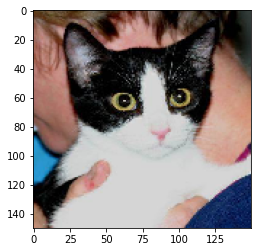

It's a cat


In [5]:
IMG_DIM = (150, 150)

try:
    train_files = glob.glob(train_dir + '/*')
    train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM), dtype='float32')/255 for img in train_files]
    train_imgs = np.array(train_imgs) # img_to_array returns numpy array already, but we have a list of them, so we convert again
    train_labels = np.asarray([1 if 'dog' in fn else 0 for fn in train_files])

    validation_files = glob.glob(val_dir + '/*')
    validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM), dtype='float32')/255 for img in validation_files]
    validation_imgs = np.array(validation_imgs) # img_to_array returns numpy array already, but we have a list of them, so we convert again
    validation_labels = np.asarray([1 if 'dog' in fn else 0 for fn in validation_files])

    print('Train dataset shape:', train_imgs.shape[0], 
    '\tValidation dataset shape:', validation_imgs.shape)
    print('Image shape:', train_imgs[0].shape)
except IndexError:
    print("\nLooks like you have problem with path delimiters. Windows users must use \\ instead of / and visa versa.")
    raise
# Test image
plt.imshow(array_to_img(train_imgs[20]))
plt.show()
# Test label
if train_labels[20] == 1:
    print("It's a dog")
else:
    print("It's a cat")

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


### Фикс GPU
Если есть проблема с видеопамятью и tensorflow, а это проблема у многих, то можно вообще выключить GPU для tensorflow. Будет в 5 раз медленнее, зато всегда работает. Может на твоём железе заработает и так. А для GPU где мало памяти может потребоваться постепенный рост аллоцированной памяти вместо аллокации большим фрагментом.

In [7]:
import tensorflow as tf

GPU_fix = "Disable" # Choose "Disable", "MemoryFix" or "None"

if GPU_fix == "Disable":
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
elif GPU_fix == "MemoryFix":
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

## Обучение CNN
Мы хотим сравнить качество между собственной архитектурой и переносом обучения. Для собственного решения зададим параметры обучения: эпохи и размер батча. Последний должен быть делителем для размера выборки.

In [8]:
batch_size = 30
epochs = 10
IMG_SHAPE = 150

In [10]:
image_gen_train = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = image_gen_train.flow(train_imgs, train_labels, batch_size=batch_size)


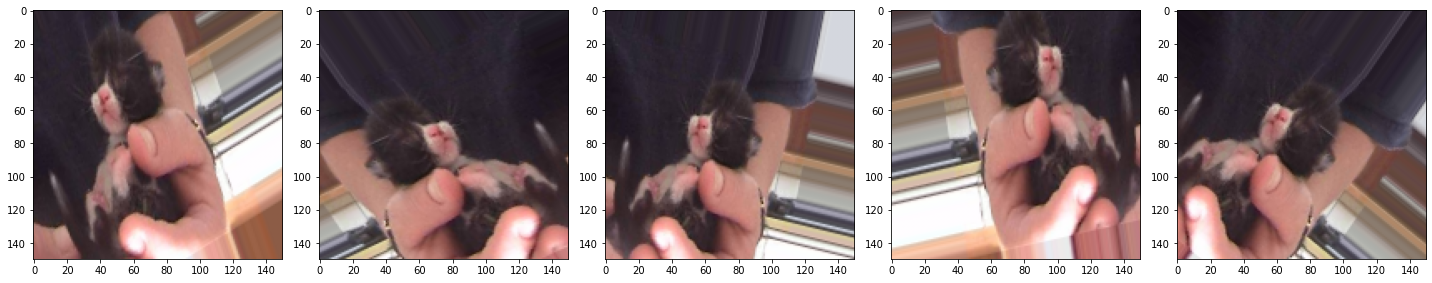

In [11]:
augmented_images = [train_data_gen[1][0][0] for i in range(5)]
plotImages(augmented_images)

In [14]:
image_gen_val = ImageDataGenerator(
    rescale=None,
)

val_data_gen = image_gen_val.flow(validation_imgs, validation_labels, batch_size=batch_size)


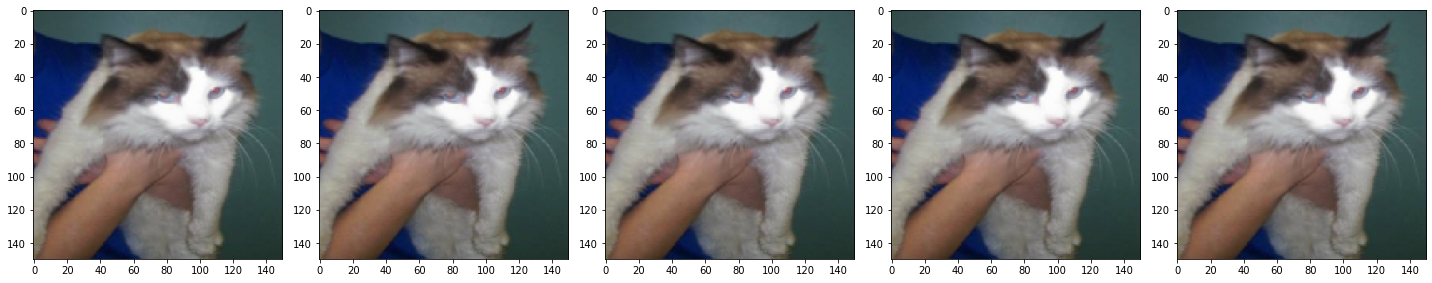

In [15]:
augmented_images = [val_data_gen[1][0][0] for i in range(5)]
plotImages(augmented_images)

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
t

In [17]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_imgs.shape[0] / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(validation_imgs.shape[0] / float(batch_size)))

)

Epoch 1/10
100/100 [==============================] - 55s 547ms/step - loss: 0.6961 - accuracy: 0.5120 - val_loss: 0.6924 - val_accuracy: 0.5620
Epoch 2/10
100/100 [==============================] - 70s 702ms/step - loss: 0.6903 - accuracy: 0.5333 - val_loss: 0.6893 - val_accuracy: 0.5190
Epoch 3/10
100/100 [==============================] - 69s 690ms/step - loss: 0.6854 - accuracy: 0.5427 - val_loss: 0.6827 - val_accuracy: 0.5700
Epoch 4/10
100/100 [==============================] - 69s 691ms/step - loss: 0.6673 - accuracy: 0.5807 - val_loss: 0.6358 - val_accuracy: 0.5860
Epoch 5/10
100/100 [==============================] - 66s 664ms/step - loss: 0.6681 - accuracy: 0.5693 - val_loss: 0.6279 - val_accuracy: 0.6290
Epoch 6/10
100/100 [==============================] - 66s 664ms/step - loss: 0.6674 - accuracy: 0.5800 - val_loss: 0.6328 - val_accuracy: 0.5890
Epoch 7/10
100/100 [==============================] - 68s 682ms/step - loss: 0.6567 - accuracy: 0.5877 - val_loss: 0.6167 - val_ac

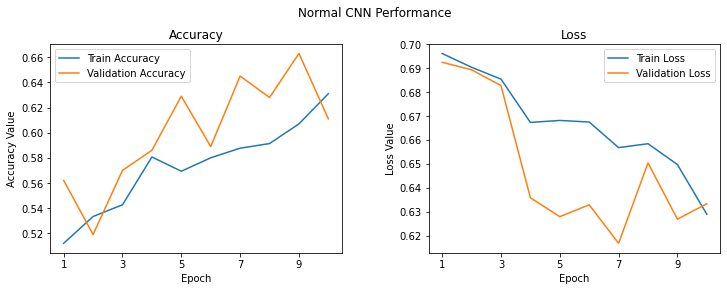

In [18]:
def show_history(history, label="Default label"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(label, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    epochs = len(history.history["loss"])

    epoch_list = list(range(1,epochs+1))
    
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, epochs+1, 2))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, epochs+1, 2))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
show_history(history, "Normal CNN Performance")

Нашу сеть построим обычным образом, чередуя Conv2D и MaxPooling2D слои, заканчивая полносвязными слоями для принятия решения на основе сверточного анализа картинки и слоем из одного нейрона чтобы его выход определял класс объекта.
<img src="TL_CNN_from_scratch.png">

In [10]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

cnn_model = Sequential()

cnn_model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=train_imgs[0].shape))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))


cnn_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

Обучим свёрточную сеть.

In [11]:
cnn_history = cnn_model.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
100/100 [==============================] - 41s 413ms/step - loss: 0.6933 - accuracy: 0.5340 - val_loss: 0.6822 - val_accuracy: 0.5710
Epoch 2/10
100/100 [==============================] - 44s 444ms/step - loss: 0.6484 - accuracy: 0.6193 - val_loss: 0.6195 - val_accuracy: 0.6530
Epoch 3/10
100/100 [==============================] - 46s 458ms/step - loss: 0.6026 - accuracy: 0.6787 - val_loss: 0.5945 - val_accuracy: 0.6640
Epoch 4/10
100/100 [==============================] - 47s 473ms/step - loss: 0.5431 - accuracy: 0.7137 - val_loss: 0.6476 - val_accuracy: 0.6730
Epoch 5/10
100/100 [==============================] - 47s 469ms/step - loss: 0.4331 - accuracy: 0.7937 - val_loss: 0.7319 - val_accuracy: 0.6680
Epoch 6/10
100/100 [==============================] - 51s 509ms/step - loss: 0.3063 - accuracy: 0.8647 - val_loss: 0.7622 - val_accuracy: 0.6950
Epoch 7/10
100/100 [==============================] - 51s 515ms/step - loss: 0.1515 - accuracy: 0.9390 - val_loss: 1.2821 - val_ac

Результаты обучения лучше всего смотреть графически. Нас интересует переобучение. Напомню. что переобучение сразу видно по отличиям графиков валидации и обучения. Для этого определим функцию, которая будет получать историю обучения и показывать точность и функцию потерь в удобном виде с подписями осей, отступами и т.п.

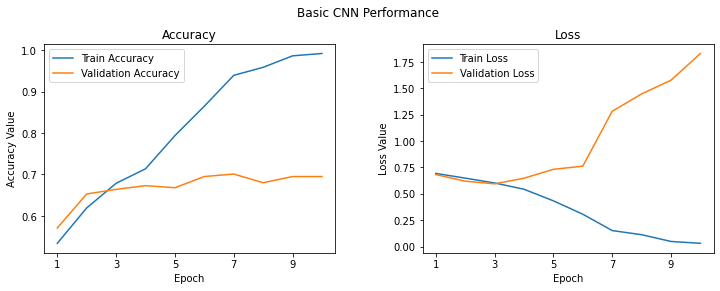

In [30]:
def show_history(history, label="Default label"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(label, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)
    epochs = len(history.history["loss"])

    epoch_list = list(range(1,epochs+1))
    
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, epochs+1, 2))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, epochs+1, 2))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

show_history(cnn_history, 'Basic CNN Performance')

Итак, модель достигла точности в 70% на валидации и с некоторой эпохи началось переобучение (увеличение потерь на валидации с ростом номера эпохи). Прежде чем перейти к переносу обучения стоит побороться с переобучением стандартными методами.

## Задание 1
Имея ту же самую выборку и другую сеть с таким же или примерно таким же количеством коэффициентов, используй известные тебе способы борьбы с переобучением, выведи графики обучения и покажи, что эффект переобучения удалось снизить.

In [69]:
cnn_model2 = tg.keras.models.Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=train_imgs[0].shape),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)), 
    
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),
                 
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(2, activation="softmax")           
])

cnn_model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

cnn_model2.summary()

SyntaxError: invalid syntax (<ipython-input-69-df412942eaf5>, line 15)

In [71]:


cnn_model2 = Sequential()

cnn_model2.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=train_imgs[0].shape))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(tf.keras.layers.Dropout(0.25))
cnn_model2.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(tf.keras.layers.Dropout(0.25))
cnn_model2.add(Conv2D(128, kernel_size=(3, 3),
                 activation='relu'))
cnn_model2.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(tf.keras.layers.Dropout(0.25))

cnn_model2.add(Flatten())
cnn_model2.add(tf.keras.layers.BatchNormalization())

cnn_model2.add(Dense(512, activation="relu"))
cnn_model2.add(tf.keras.layers.Dropout(0.6))

cnn_model2.add(Dense(2, activation="sigmoid"))

cnn_model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

cnn_model2.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 34, 34, 128)     

In [68]:
cnn_history2 = cnn_model2.fit(x=train_imgs, y=train_labels,
                    validation_data=(validation_imgs, validation_labels),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/10
100/100 [==============================] - 50s 503ms/step - loss: 1.3514 - accuracy: 0.5583 - val_loss: 0.7218 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 61s 607ms/step - loss: 0.6500 - accuracy: 0.6110 - val_loss: 0.6833 - val_accuracy: 0.6410
Epoch 3/10
100/100 [==============================] - 67s 668ms/step - loss: 0.6205 - accuracy: 0.6433 - val_loss: 0.6727 - val_accuracy: 0.5690
Epoch 4/10
100/100 [==============================] - 69s 692ms/step - loss: 0.6075 - accuracy: 0.6613 - val_loss: 0.6798 - val_accuracy: 0.5490
Epoch 5/10
100/100 [==============================] - 73s 727ms/step - loss: 0.6111 - accuracy: 0.6747 - val_loss: 0.7304 - val_accuracy: 0.5190
Epoch 6/10
100/100 [==============================] - 71s 705ms/step - loss: 0.5758 - accuracy: 0.6953 - val_loss: 0.5905 - val_accuracy: 0.6730
Epoch 7/10
100/100 [==============================] - 71s 714ms/step - loss: 0.5663 - accuracy: 0.7030 - val_loss: 0.5633 - val_ac

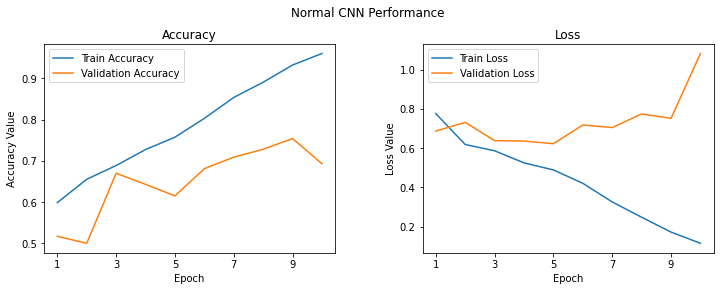

In [66]:
show_history(cnn_history2, 'Normal CNN Performance')

## Перенос обучения с VGG16
Вспомним основные свойства VGG16. Эта сеть тренировалась на ImageNet с 1000 классами (там есть несколько пород собак и кошки). Эта сеть - классификатор. Она имеет традиционную архитектуру сверточных сетей. Нам нужно выделить место, где появляются высокоуровневые свойства изображения. Это будет последний MaxPooling слой перед полносвязными слоями анализа этих свойств.
<img src="TL_VGG16_structure.png">

Вспоминаем, что есть 2 способа использовать перенос обучения: использования готового анализа свойств изображения (feature extraction) и точная подстройка (fine tuning).
<img src="TL_VGG16_learning_strategy.png">
Мы начнём с использования свойств.

### Перенос свойств (Feature extraction)
Мы воспользуемся готовой моделью из библиотеки `tensorflow.keras.applications`. Она импортируется из интернета автоматически, но мы должны указать, включать ли полносвязные слои на выходе (`include_top`). Они нам как раз и не нужны. А вот веса `weights` нужны. Мы задаём в `input_shape` размерность входных изображений, которую выбрали в начале. Это что-то новенькое. Мы берём обученную сеть с фиксированной архитектурой и говорим ей какое будет входное разрешение. Не масштабируем изображения к некому стандарту, как в YOLO, а именно выбираем любое разрешение. Каким образом удаётся поменять эту размерность, если сеть уже готовая и обученная?

Далее соорудим модель как vgg16 со слоем Flatten в конце. Нам важно сделать всю эту модель неизменяемой, чтобы не сломать те умения, что мы собираемся переиспользовать. Они и так хороши.

In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow as tf

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=train_imgs[0].shape)

# We want to attach 
output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

Теперь мы можем взять готовую, неизменяемую модель с выводом всех итоговых сигналов и применить её к нашей выборке. Мы тогда получим новую выборку, состоящую из неких важных свойств нашей исходной выборки.

In [ ]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features
    
train_features_vgg = get_bottleneck_features(vgg_model, train_imgs)
validation_features_vgg = get_bottleneck_features(vgg_model, validation_imgs)

print('Train Bottleneck Features:', train_features_vgg.shape, 
'\tValidation Bottleneck Features:', validation_features_vgg.shape)

Собственно от VGG16 мы уже всё, что нужно, получили. Теперь мы можем обучить нашу новую сеть на выборке с суффиксом `_vgg`. Сеть мы сразу возьмём такую же, как была у нас свёрточная, но всю сверточную часть опустим, ведь мы её взяли из VGG16.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

input_shape = vgg_model.output_shape[1]

vggfe_model = Sequential()
vggfe_model.add(InputLayer(input_shape=(input_shape,)))
vggfe_model.add(Dense(512, activation='relu', input_dim=input_shape))
vggfe_model.add(Dense(512, activation='relu'))
vggfe_model.add(Dense(1, activation='sigmoid'))

vggfe_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

vggfe_model.summary()

Обучим нашу сеть.

In [ ]:
vggfe_history = vggfe_model.fit(x=train_features_vgg, y=train_labels,
                    validation_data=(validation_features_vgg, validation_labels),
                    batch_size=batch_size,
                    epochs=30,
verbose=1)
show_history(vggfe_history, label = "Pretrained CNN transfer learning with feature extraction")

Заметил как быстро сеть обучилась? Заметил, что точность на валидации возрасла до 88%? Вот это сила переноса обучения. Кстати, здесь мы тоже с переобучением не боролись, так что можешь модифицировать сеть тем же способом и еще повысить результат.
### Задание 2
Метод классификации построен и даёт хорошие результаты, а теперь нужно воспользоваться этим методом и предсказать класс случайной картинки из набора для валидации. напиши код, дающий значение `prediction`.

In [ ]:
random_val_image = np.random.randint(0, len(validation_imgs))

prediction = np.argmax(model.predict(random_val_image), 1)

if prediction < 0.5:
    print("Prediction: It's a cat.")
else:
    print("Prediction: It's a dog.")
print("Actually it's a {}.".format("dog" if validation_labels[random_val_image] else "cat"))
plt.imshow(array_to_img(validation_imgs[random_val_image]))
plt.show()

### Точная подстройка (Fine tuning)
Теперь мы можем попробовать донастроить сеть. Для этого мы выберем 1 или 2 последних блока и пометим все их слои, как обучаемые.
### Задание 3
Пометь в vgg модели слои последних 1-2 блоков, как обучаемые.

In [ ]:
# Type your code here

vgg_model.summary()

Теперь мы можем сделать сеть, которая начинается с vgg с частично разблокированными коэффициентами, а продолжается нашими стандартными полносвязными слоями. Только надо использовать небольшой коэффициент градиента, чтобы не раскачать в первую очередь слои от VGG16.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

vggft_model = Sequential()
vggft_model.add(vgg_model)
vggft_model.add(Dense(512, activation='relu', input_dim=input_shape))
vggft_model.add(Dense(512, activation='relu'))
vggft_model.add(Dense(1, activation='sigmoid'))

vggft_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])

vggft_model.summary()

In [ ]:
vggft_history = vggft_model.fit(x=train_imgs, y=train_labels,
                                epochs=10,
                                validation_data=(validation_imgs, validation_labels),
                                batch_size=batch_size,
                                verbose=1)
show_history(vggft_history, "Pretrained CNN with feature extraction after fine tuning")

Если всё сделано правильно, то fine tuning даст 95% процентов accuracy на валидации. Это самый высокий параметр для этого датасета. Напомним, что с таким небольшим датасетом у нас не будет возможности достичь подобного результата без переноса обучения.

## Ссылки
Объяснения применения TL: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

Иллюстрации к приёмам переноса обучения, примеры, код, графики и показ ошибок, лонгрид: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a